In [64]:
import os.path as osp
import numpy as np
import pickle
from tqdm import tqdm 

import matplotlib.pyplot as plt
from PIL import Image

import torch
from torch import nn
from torchvision import transforms
from torch import optim

import carla_visual as cv
from carla_visual.dataloaders.online_dataset import load_online_dataset, build_dataloader

from carla_visual.models.classifiers import PIECECNN
from carla_visual.models.generators import PIECEGenerator

from carla_visual.models.utils import fetch_weights, load_model_weights
import carla_visual.evaluation.evaluate_prediction_model as epm

import carla_visual.recourse_methods.piece.utils as putils  
from carla_visual.plotting.plot_output import plot_misclassifications

from carla_visual.plotting.plot_output import plot_image  

In [65]:
np.random.seed(0)
torch.manual_seed(0);

# Prepare data

In [91]:
ds_name = 'MNIST'
data_root = 'D:\PycharmProjects\XAIRobustness\data\images'

train_data, test_data = load_online_dataset(ds_name, data_root, download=False)
print(f'Shape of the train set: ', train_data.data.shape)
print(f'Shape of the test set: ', test_data.data.shape)

Shape of the train set:  torch.Size([60000, 28, 28])
Shape of the test set:  torch.Size([10000, 28, 28])


In [102]:
from torch.utils.data import DataLoader


indices = torch.nonzero(test_data.targets==1)
images = test_data.data[indices].float()
dl = DataLoader(images, batch_size=64)

for d in dl:
    print(d.dtype)

torch.float32
torch.float32
torch.float32
torch.float32
torch.float32
torch.float32
torch.float32
torch.float32
torch.float32
torch.float32
torch.float32
torch.float32
torch.float32
torch.float32
torch.float32
torch.float32
torch.float32
torch.float32


In [67]:
input_shape = (28, 28, 1)
input_chn = input_shape[-1]
num_classes = 10
batch_size = 1
nz = 100
device = 'cuda' if torch.cuda.is_available() else 'cpu'
ngpu = 0 if device == 'cpu' else 1


In [68]:
train_dataloader, test_dataloader = build_dataloader([train_data, test_data], 
                                                      batch_size=batch_size, 
                                                      shuffle=False)

# Load pre-trained CNN and Generator 

In [6]:
original_cnn_weights = 'https://github.com/EoinKenny/AAAI-2021/raw/refs/heads/master/weights/pytorch_cnn.pth'
original_gen_weights = 'https://github.com/EoinKenny/AAAI-2021/raw/refs/heads/master/weights/generator.pth'

output_dir = 'D:\PycharmProjects\XAIRobustness\CARLA_VISUAL\carla_visual\models\weights\piece'
cnn_weights_file = 'cnn_weights.pth'
gen_weights_file = 'generator_weights.pth'


In [22]:
fetch_weights(original_cnn_weights, file_name=cnn_weights_file, output_dir=output_dir)
fetch_weights(original_gen_weights, file_name=gen_weights_file, output_dir=output_dir)

In [7]:
cnn = PIECECNN(input_chn, num_classes)
print('Total number of parameters in the CNN:', cnn.get_params_num())
cnn = load_model_weights(cnn, osp.join(output_dir, cnn_weights_file), device=device)

Total number of parameters in the CNN: 143162


In [8]:
print('Accuracy of the pre-trained CNN: ', epm.evaluate_model(cnn, test_dataloader, device)['accuracy'])

Evaluating: 100%|██████████| 10000/10000 [01:06<00:00, 150.95it/s]

Accuracy of the pre-trained CNN:  0.9932


In [8]:
gen = PIECEGenerator(ngpu=ngpu)
gen = load_model_weights(gen, osp.join(output_dir, gen_weights_file), device=device)

Check the generative performance of the loaded generator 

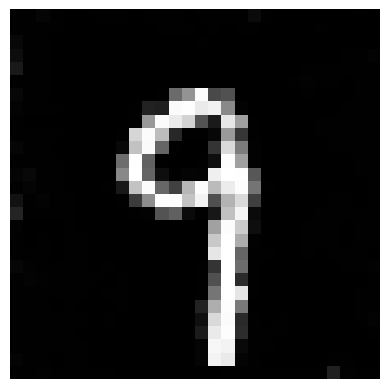

In [10]:
z = torch.randn(batch_size, nz)
z = z.view(z.size(0), nz, 1, 1)
generated_images = gen(z)
plot_image(generated_images) 

# PIECE Algorithm  #

PIECE algorithm generates counterfactual explanations for the given misclassified test instances. Therefore, the target counterfactual class is a correct label. In case of the correct classification, a target cf class is chosen during the optimization problem using a gradient ascent. The goal is to choose a target cf class when a desicion boundary is crossed for the first time. 
The following experiments are based on the provided implementation for misclassified instances. 

1) Obtaining misclassified instances 

In [16]:
# Upload already calculated misclassified instances which is a list of tuples with an original misclasssified image, a ground-truth label, and a predicted label

LOAD_MISCLASSIFIED_SAMPLES = True

if LOAD_MISCLASSIFIED_SAMPLES:
    misclf_samples_path = r'D:\PycharmProjects\XAIRobustness\CARLA_VISUAL\carla_visual\recourse_methods\piece\misclassified_instances\misclassified_instances.pickle'

    with open(misclf_samples_path, 'rb') as f:
        misclf_samples = pickle.load(f)
else:
    misclf_samples = putils.get_misclassifications(cnn, test_dataloader, device) 
    print('Number of misclassified test images: ', len(misclf_samples))

    with open(r'D:\PycharmProjects\XAIRobustness\CARLA_VISUAL\carla_visual\recourse_methods\piece\misclassified_instances\misclassified_instances.pickle', 'wb') as f:
        pickle.dump(misclf_samples, f)

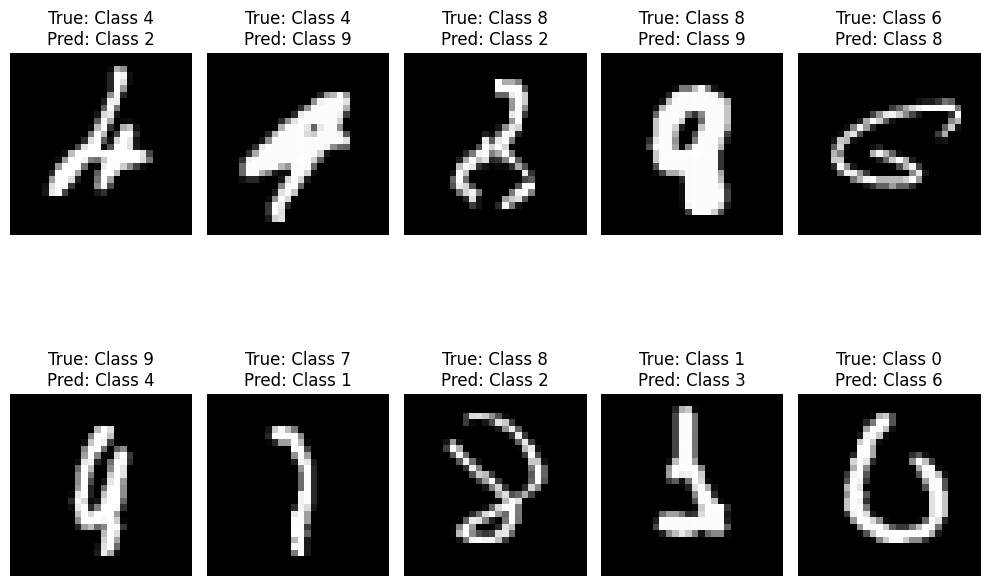

In [10]:
plot_misclassifications(misclf_samples[:10])

2) Identifying the latent vector that corresponds to the given misclassified image

In [20]:
LOAD_MISCLF_AND_LV = True

if LOAD_MISCLF_AND_LV:
    misclf_samples_info_path = r'D:\PycharmProjects\XAIRobustness\CARLA_VISUAL\carla_visual\recourse_methods\piece\misclassified_instances\misclassified_instances_and_latent_vectors.pickle'

    with open(misclf_samples_info_path, 'rb') as f:
        misclf_samples_info = pickle.load(f)

else:
    misclf_samples_info = []

    for mscl_sample in tqdm(misclf_samples):
        img, label, pred = mscl_sample
        img = img.unsqueeze(0)
        latent_vector = putils.optimize_z0(gen, cnn.main, img, nz, num_iterations=400)
        sample_info = {'image': img, 'label': label, 
                    'prediction': pred, 'latent_vector': latent_vector}
        misclf_samples_info.append(sample_info) 

    # Save calculated latent vectors 
    misclf_samples_info_path = r'D:\PycharmProjects\XAIRobustness\CARLA_VISUAL\carla_visual\recourse_methods\piece\misclassified_instances\misclassified_instances_and_latent_vectors.pickle'

    with open(misclf_samples_info_path, 'wb') as f:
        pickle.dump(misclf_samples_info, f)


100%|██████████| 68/68 [14:17<00:00, 12.62s/it]


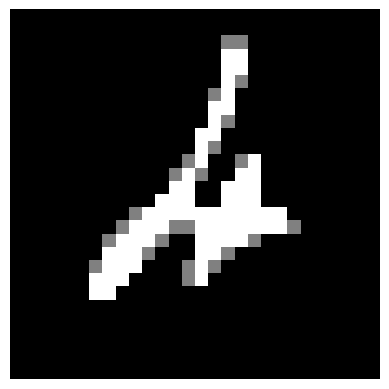

In [22]:
original_query_img = misclf_samples_info[0]['image']
plot_image(original_query_img)

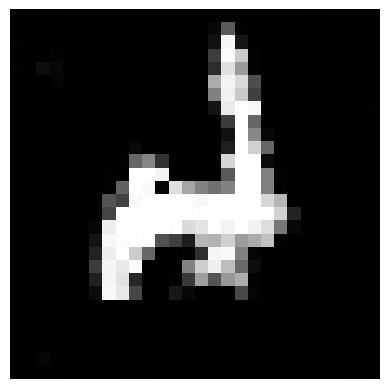

In [23]:
plot_image(gen(misclf_samples_info[0]['latent_vector']))

In [18]:
query_activations = cnn(gen(z_I))[1][0]

3) Constructing a latent dataset for training data (THE FUNCTION 'return_feature_contribution_data' IS TIME-CONSUMING!)

In [25]:
LOAD_LATENT_ACTIVATIONS = True 

latent_ds_path = r'D:\PycharmProjects\XAIRobustness\CARLA_VISUAL\carla_visual\recourse_methods\piece\latent_activations\latent_mnist_dataset.pickle'


if not LOAD_LATENT_ACTIVATIONS:
    # On this step, we construct a latent datset that constitute the logits of the all training data and the corresponding for them predictions 
    latent_ds = putils.return_feature_contribution_data(train_dataloader, cnn, num_classes=10)

    # Pickle calculated activations and their corresponding predictions
    with open(latent_ds_path, 'wb') as handle:
        pickle.dump(latent_ds, handle, protocol=pickle.HIGHEST_PROTOCOL)
else:
    # Load pre-calculated latent dataset
    with open(latent_ds_path, 'rb') as handle:
        latent_ds = pickle.load(handle)

4) Step 1: Acquire the probability of each features, and identify the excpetional ones (i.e., those with a probability lower than alpha)

5) Step 2: Filter out exceptional features which we want to change, and change them to their expected values in the counterfactual class

In [26]:
alpha = 0.05

In [35]:
misclf_batch_feature_probs = []

for i, instance in tqdm(enumerate(misclf_samples_info)):
    print(f'Processing instance {i} for the generation of counterfactual explanation')
    query_image = instance['image']
    query_label = instance['label'].detach().item()
    query_latent_vector = instance['latent_vector']
    query_prediction = instance['prediction'].detach().numpy()
    query_activations =  cnn(gen(query_latent_vector))[1][0]

    print('Identifying the most expectional features')
    df = putils.acquire_feature_probabilities(latent_ds, query_label, cnn, query_image, alpha)
    df = putils.filter_df_of_exceptional_noise(df, query_label, cnn, alpha)
    # Sort by least probable to the most probable
    df = df.sort_values('Probability of Event')

    print('Correcting the activations X')
    # Get x' -- The Ideal Explanation
    cor_activations = putils.modifying_exceptional_features(df, query_label, query_activations)   
    cor_activations = cor_activations.clone().detach().float().requires_grad_(False)

    print('Optimizing the latent vector')
    cor_latent_vector = putils.optim_PIECE(gen, cnn, cor_activations, query_latent_vector)
    misclf_samples_info[i]['corrected_activation'] = cor_activations
    misclf_samples_info[i]['corrected_latent_vector'] = cor_latent_vector


0it [00:00, ?it/s]

Processing instance 0 for the generation of counterfactual explanation
Identifying the most expectional features


d:\pycharmprojects\xairobustness\carla_visual\carla_visual\recourse_methods\piece\utils.py:226: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_new['flag'] = 0


Exceptions(?):  [16, 37, 106, 115]
The length of the latent datset before and after filtering: (128, 10) | (60, 10)
Number of noisy exceptional features deleted: 68
Correcting the activations X
Optimizing the latent vector
Loss: 0.007391198072582483
Loss: 0.005797310266643763
Loss: 0.005782019812613726
Loss: 0.005773212760686874
Loss: 0.005765813868492842
Loss: 0.005757696460932493
Loss: 0.005750156007707119
Loss: 0.005742586217820644
Loss: 0.005734917242079973
Loss: 0.00572773814201355


1it [00:31, 31.37s/it]

Processing instance 1 for the generation of counterfactual explanation
Identifying the most expectional features


d:\pycharmprojects\xairobustness\carla_visual\carla_visual\recourse_methods\piece\utils.py:226: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_new['flag'] = 0


Exceptions(?):  [42]
The length of the latent datset before and after filtering: (128, 10) | (63, 10)
Number of noisy exceptional features deleted: 65
Correcting the activations X
Optimizing the latent vector
Loss: 0.005245736800134182
Loss: 0.003991015255451202
Loss: 0.003764460328966379
Loss: 0.003674248466268182
Loss: 0.003619380760937929
Loss: 0.003591768676415086
Loss: 0.0035713729448616505
Loss: 0.0035544047132134438
Loss: 0.0035383817739784718
Loss: 0.003523018676787615


2it [01:04, 32.19s/it]

Processing instance 2 for the generation of counterfactual explanation
Identifying the most expectional features


d:\pycharmprojects\xairobustness\carla_visual\carla_visual\recourse_methods\piece\utils.py:226: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_new['flag'] = 0


Exceptions(?):  [47, 73, 75, 110, 113, 117, 126]
The length of the latent datset before and after filtering: (128, 10) | (72, 10)
Number of noisy exceptional features deleted: 56
Correcting the activations X
Optimizing the latent vector
Loss: 0.0115139689296484
Loss: 0.0106825465336442
Loss: 0.01014158595353365
Loss: 0.0099916011095047
Loss: 0.009867901913821697
Loss: 0.00978558138012886
Loss: 0.009686935693025589
Loss: 0.009601837955415249
Loss: 0.009545840322971344
Loss: 0.009503873065114021


3it [01:42, 34.95s/it]

Processing instance 3 for the generation of counterfactual explanation
Identifying the most expectional features


d:\pycharmprojects\xairobustness\carla_visual\carla_visual\recourse_methods\piece\utils.py:226: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_new['flag'] = 0


Exceptions(?):  [66, 99]
The length of the latent datset before and after filtering: (128, 10) | (65, 10)
Number of noisy exceptional features deleted: 63
Correcting the activations X
Optimizing the latent vector
Loss: 0.05162421613931656
Loss: 0.0485432893037796
Loss: 0.04710545018315315
Loss: 0.04612857848405838
Loss: 0.04515368118882179
Loss: 0.04441763833165169
Loss: 0.04393983259797096
Loss: 0.04343479499220848
Loss: 0.04269997030496597
Loss: 0.04216194897890091


4it [02:17, 35.10s/it]

Processing instance 4 for the generation of counterfactual explanation
Identifying the most expectional features


d:\pycharmprojects\xairobustness\carla_visual\carla_visual\recourse_methods\piece\utils.py:226: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_new['flag'] = 0


Exceptions(?):  [98]
The length of the latent datset before and after filtering: (128, 10) | (51, 10)
Number of noisy exceptional features deleted: 77
Correcting the activations X
Optimizing the latent vector
Loss: 0.006898417137563229
Loss: 0.005577011965215206
Loss: 0.004875827115029097
Loss: 0.004664108157157898
Loss: 0.004578916821628809
Loss: 0.004539750516414642
Loss: 0.004512676503509283
Loss: 0.004500254523009062
Loss: 0.004489907994866371
Loss: 0.004480072297155857


5it [02:56, 36.46s/it]

Processing instance 5 for the generation of counterfactual explanation
Identifying the most expectional features


d:\pycharmprojects\xairobustness\carla_visual\carla_visual\recourse_methods\piece\utils.py:226: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_new['flag'] = 0


Exceptions(?):  [31, 33, 47, 54, 55, 61, 63, 81, 89, 104, 123]
The length of the latent datset before and after filtering: (128, 10) | (75, 10)
Number of noisy exceptional features deleted: 53
Correcting the activations X
Optimizing the latent vector
Loss: 0.008232442662119865
Loss: 0.007702896371483803
Loss: 0.00763321528211236
Loss: 0.0075571537017822266
Loss: 0.006773156579583883
Loss: 0.006657414138317108
Loss: 0.0065913330763578415
Loss: 0.00654166005551815
Loss: 0.006438275799155235
Loss: 0.00637428555637598


6it [03:34, 36.88s/it]

Processing instance 6 for the generation of counterfactual explanation
Identifying the most expectional features


d:\pycharmprojects\xairobustness\carla_visual\carla_visual\recourse_methods\piece\utils.py:226: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_new['flag'] = 0


Exceptions(?):  [15, 22, 48, 80, 99, 121]
The length of the latent datset before and after filtering: (128, 10) | (58, 10)
Number of noisy exceptional features deleted: 70
Correcting the activations X
Optimizing the latent vector
Loss: 0.024566352367401123
Loss: 0.02129431813955307
Loss: 0.0193219855427742
Loss: 0.017854612320661545
Loss: 0.016946913674473763
Loss: 0.016597969457507133
Loss: 0.016280852258205414
Loss: 0.015998760238289833
Loss: 0.01551438495516777
Loss: 0.015091217122972012


7it [04:10, 36.58s/it]

Processing instance 7 for the generation of counterfactual explanation
Identifying the most expectional features


d:\pycharmprojects\xairobustness\carla_visual\carla_visual\recourse_methods\piece\utils.py:226: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_new['flag'] = 0


Exceptions(?):  [0, 13, 18, 29, 58, 73, 75, 110, 125]
The length of the latent datset before and after filtering: (128, 10) | (71, 10)
Number of noisy exceptional features deleted: 57
Correcting the activations X
Optimizing the latent vector
Loss: 0.022869199514389038
Loss: 0.020867938175797462
Loss: 0.02016800455749035
Loss: 0.019795240834355354
Loss: 0.019362162798643112
Loss: 0.019086480140686035
Loss: 0.018900834023952484
Loss: 0.01871110498905182
Loss: 0.018488921225070953
Loss: 0.01826687529683113


8it [04:44, 35.70s/it]

Processing instance 8 for the generation of counterfactual explanation
Identifying the most expectional features


d:\pycharmprojects\xairobustness\carla_visual\carla_visual\recourse_methods\piece\utils.py:226: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_new['flag'] = 0


Exceptions(?):  [8, 10, 12, 14, 27, 29, 41, 44, 47, 64, 73, 76, 81, 83, 85, 109, 113, 122, 123, 125]
The length of the latent datset before and after filtering: (128, 10) | (67, 10)
Number of noisy exceptional features deleted: 61
Correcting the activations X
Optimizing the latent vector
Loss: 0.006100550293922424
Loss: 0.005311734974384308
Loss: 0.005249631591141224
Loss: 0.005150852724909782
Loss: 0.005102221388369799
Loss: 0.0050586313009262085
Loss: 0.005043477285653353
Loss: 0.005034582689404488
Loss: 0.005026466678828001
Loss: 0.005021283868700266


9it [05:25, 37.47s/it]

Processing instance 9 for the generation of counterfactual explanation
Identifying the most expectional features


d:\pycharmprojects\xairobustness\carla_visual\carla_visual\recourse_methods\piece\utils.py:226: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_new['flag'] = 0


Exceptions(?):  [24, 45, 49, 59, 66, 71, 84, 87, 98, 100, 101, 103, 107, 126]
The length of the latent datset before and after filtering: (128, 10) | (71, 10)
Number of noisy exceptional features deleted: 57
Correcting the activations X
Optimizing the latent vector
Loss: 0.002707390347495675
Loss: 0.0021656553726643324
Loss: 0.0020773853175342083
Loss: 0.0020422963425517082
Loss: 0.0020184714812785387
Loss: 0.0019922892097383738
Loss: 0.001969934906810522
Loss: 0.0019502041395753622
Loss: 0.0019298434490337968
Loss: 0.001905130222439766


10it [05:59, 36.45s/it]

Processing instance 10 for the generation of counterfactual explanation
Identifying the most expectional features


d:\pycharmprojects\xairobustness\carla_visual\carla_visual\recourse_methods\piece\utils.py:226: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_new['flag'] = 0


Exceptions(?):  [0, 13, 14, 17, 27, 40, 62, 73, 76, 85, 91, 110, 113, 118, 125]
The length of the latent datset before and after filtering: (128, 10) | (75, 10)
Number of noisy exceptional features deleted: 53
Correcting the activations X
Optimizing the latent vector
Loss: 0.00593540770933032
Loss: 0.005638883449137211
Loss: 0.005447419360280037
Loss: 0.005321998614817858
Loss: 0.005271760746836662
Loss: 0.005230064038187265
Loss: 0.005200743675231934
Loss: 0.005173252895474434
Loss: 0.005158645566552877
Loss: 0.005143372341990471


11it [06:41, 38.00s/it]

Processing instance 11 for the generation of counterfactual explanation
Identifying the most expectional features


d:\pycharmprojects\xairobustness\carla_visual\carla_visual\recourse_methods\piece\utils.py:226: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_new['flag'] = 0


Exceptions(?):  [36, 42, 53, 60, 70, 94, 98, 118]
The length of the latent datset before and after filtering: (128, 10) | (65, 10)
Number of noisy exceptional features deleted: 63
Correcting the activations X
Optimizing the latent vector
Loss: 0.01090258825570345
Loss: 0.009320376440882683
Loss: 0.008794981986284256
Loss: 0.008227159269154072
Loss: 0.007452311925590038
Loss: 0.007027032319456339
Loss: 0.0066508031450212
Loss: 0.006299477536231279
Loss: 0.006029353942722082
Loss: 0.005892784800380468


12it [07:16, 37.18s/it]

Processing instance 12 for the generation of counterfactual explanation
Identifying the most expectional features


d:\pycharmprojects\xairobustness\carla_visual\carla_visual\recourse_methods\piece\utils.py:226: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_new['flag'] = 0


Exceptions(?):  [36, 58, 75, 113, 117, 126]
The length of the latent datset before and after filtering: (128, 10) | (92, 10)
Number of noisy exceptional features deleted: 36
Correcting the activations X
Optimizing the latent vector
Loss: 0.009438827633857727
Loss: 0.008402830921113491
Loss: 0.0082966024056077
Loss: 0.00822425913065672
Loss: 0.008161074481904507
Loss: 0.008112247101962566
Loss: 0.008064957335591316
Loss: 0.008028583601117134
Loss: 0.007963708601891994
Loss: 0.007921010255813599


13it [07:52, 36.71s/it]

Processing instance 13 for the generation of counterfactual explanation
Identifying the most expectional features


d:\pycharmprojects\xairobustness\carla_visual\carla_visual\recourse_methods\piece\utils.py:226: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_new['flag'] = 0


Exceptions(?):  [31, 55, 63, 81, 89, 104]
The length of the latent datset before and after filtering: (128, 10) | (60, 10)
Number of noisy exceptional features deleted: 68
Correcting the activations X
Optimizing the latent vector
Loss: 0.05873939394950867
Loss: 0.0578707680106163
Loss: 0.057142533361911774
Loss: 0.05654841288924217
Loss: 0.05620916187763214
Loss: 0.0560070164501667
Loss: 0.055835749953985214
Loss: 0.055688004940748215
Loss: 0.05554640293121338
Loss: 0.055402740836143494


14it [08:27, 36.42s/it]

Processing instance 14 for the generation of counterfactual explanation
Identifying the most expectional features


d:\pycharmprojects\xairobustness\carla_visual\carla_visual\recourse_methods\piece\utils.py:226: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_new['flag'] = 0


Exceptions(?):  [30, 32, 39, 54, 57, 58, 78, 90, 94, 104, 124]
The length of the latent datset before and after filtering: (128, 10) | (98, 10)
Number of noisy exceptional features deleted: 30
Correcting the activations X
Optimizing the latent vector
Loss: 0.053524553775787354
Loss: 0.0517265722155571
Loss: 0.05148635059595108
Loss: 0.05087905377149582
Loss: 0.05041753128170967
Loss: 0.05002834275364876
Loss: 0.04967004433274269
Loss: 0.04921388253569603
Loss: 0.04879932850599289
Loss: 0.048237431794404984


15it [09:00, 35.17s/it]

Processing instance 15 for the generation of counterfactual explanation
Identifying the most expectional features


d:\pycharmprojects\xairobustness\carla_visual\carla_visual\recourse_methods\piece\utils.py:226: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_new['flag'] = 0


Exceptions(?):  [55, 61, 90]
The length of the latent datset before and after filtering: (128, 10) | (76, 10)
Number of noisy exceptional features deleted: 52
Correcting the activations X
Optimizing the latent vector
Loss: 0.017180070281028748
Loss: 0.016866572201251984
Loss: 0.01676325500011444
Loss: 0.01665758714079857
Loss: 0.016534801572561264
Loss: 0.016429632902145386
Loss: 0.016314076259732246
Loss: 0.016195211559534073
Loss: 0.01605829782783985
Loss: 0.015923572704195976


16it [09:36, 35.53s/it]

Processing instance 16 for the generation of counterfactual explanation
Identifying the most expectional features


d:\pycharmprojects\xairobustness\carla_visual\carla_visual\recourse_methods\piece\utils.py:226: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_new['flag'] = 0


Exceptions(?):  [3, 5, 26, 39, 42, 58, 65, 94, 100, 113, 127]
The length of the latent datset before and after filtering: (128, 10) | (75, 10)
Number of noisy exceptional features deleted: 53
Correcting the activations X
Optimizing the latent vector
Loss: 0.017554789781570435
Loss: 0.01572212018072605
Loss: 0.015242929570376873
Loss: 0.014724240638315678
Loss: 0.013474875129759312
Loss: 0.012027416378259659
Loss: 0.011355135589838028
Loss: 0.010985622182488441
Loss: 0.010753972455859184
Loss: 0.010449671186506748


17it [10:12, 35.57s/it]

Processing instance 17 for the generation of counterfactual explanation
Identifying the most expectional features


d:\pycharmprojects\xairobustness\carla_visual\carla_visual\recourse_methods\piece\utils.py:226: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_new['flag'] = 0


Exceptions(?):  [14, 21, 22, 35, 40, 55, 80, 89, 90, 112, 116, 121]
The length of the latent datset before and after filtering: (128, 10) | (70, 10)
Number of noisy exceptional features deleted: 58
Correcting the activations X
Optimizing the latent vector
Loss: 0.019585419446229935
Loss: 0.018914930522441864
Loss: 0.018781699240207672
Loss: 0.018644025549292564
Loss: 0.018553204834461212
Loss: 0.01847059652209282
Loss: 0.01840495876967907
Loss: 0.018347330391407013
Loss: 0.018293926492333412
Loss: 0.018235240131616592


18it [10:49, 36.10s/it]

Processing instance 18 for the generation of counterfactual explanation
Identifying the most expectional features


d:\pycharmprojects\xairobustness\carla_visual\carla_visual\recourse_methods\piece\utils.py:226: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_new['flag'] = 0


Exceptions(?):  [1, 10, 26, 43, 61, 81, 83, 108, 111, 113, 122, 124, 126]
The length of the latent datset before and after filtering: (128, 10) | (56, 10)
Number of noisy exceptional features deleted: 72
Correcting the activations X
Optimizing the latent vector
Loss: 0.00825466401875019
Loss: 0.007015097886323929
Loss: 0.006908302195370197
Loss: 0.006854251492768526
Loss: 0.006818999070674181
Loss: 0.006788262166082859
Loss: 0.006760107818990946
Loss: 0.00672465655952692
Loss: 0.006696199998259544
Loss: 0.006677515339106321


19it [11:30, 37.52s/it]

Processing instance 19 for the generation of counterfactual explanation
Identifying the most expectional features


d:\pycharmprojects\xairobustness\carla_visual\carla_visual\recourse_methods\piece\utils.py:226: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_new['flag'] = 0


Exceptions(?):  [2, 8, 10, 12, 14, 26, 27, 41, 44, 47, 73, 76, 81, 83, 85, 97, 109, 113, 122, 123]
The length of the latent datset before and after filtering: (128, 10) | (62, 10)
Number of noisy exceptional features deleted: 66
Correcting the activations X
Optimizing the latent vector
Loss: 0.00563837168738246
Loss: 0.005343735218048096
Loss: 0.005258252844214439
Loss: 0.005231377203017473
Loss: 0.005208173301070929
Loss: 0.005185078829526901
Loss: 0.005166396498680115
Loss: 0.0051496801897883415
Loss: 0.005123309791088104
Loss: 0.005074342712759972


20it [12:09, 37.97s/it]

Processing instance 20 for the generation of counterfactual explanation
Identifying the most expectional features


d:\pycharmprojects\xairobustness\carla_visual\carla_visual\recourse_methods\piece\utils.py:226: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_new['flag'] = 0


Exceptions(?):  [3, 5, 28, 32, 33, 75, 102, 103, 105, 112, 120]
The length of the latent datset before and after filtering: (128, 10) | (66, 10)
Number of noisy exceptional features deleted: 62
Correcting the activations X
Optimizing the latent vector
Loss: 0.01685313694179058
Loss: 0.01643848977982998
Loss: 0.016313649713993073
Loss: 0.0162039864808321
Loss: 0.016112111508846283
Loss: 0.016039017587900162
Loss: 0.01596459187567234
Loss: 0.015893051400780678
Loss: 0.015847207978367805
Loss: 0.01580878533422947


21it [12:45, 37.31s/it]

Processing instance 21 for the generation of counterfactual explanation
Identifying the most expectional features


d:\pycharmprojects\xairobustness\carla_visual\carla_visual\recourse_methods\piece\utils.py:226: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_new['flag'] = 0


Exceptions(?):  [15, 52, 55, 81, 82, 90, 98, 104, 117, 120]
The length of the latent datset before and after filtering: (128, 10) | (62, 10)
Number of noisy exceptional features deleted: 66
Correcting the activations X
Optimizing the latent vector
Loss: 0.039073411375284195
Loss: 0.037678468972444534
Loss: 0.03730223700404167
Loss: 0.03717157244682312
Loss: 0.03707445412874222
Loss: 0.03698185086250305
Loss: 0.03689106926321983
Loss: 0.036824457347393036
Loss: 0.036761000752449036
Loss: 0.036689240485429764


22it [13:21, 37.09s/it]

Processing instance 22 for the generation of counterfactual explanation
Identifying the most expectional features


d:\pycharmprojects\xairobustness\carla_visual\carla_visual\recourse_methods\piece\utils.py:226: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_new['flag'] = 0


Exceptions(?):  [4, 22, 35, 40, 80, 91, 110, 119, 121]
The length of the latent datset before and after filtering: (128, 10) | (77, 10)
Number of noisy exceptional features deleted: 51
Correcting the activations X
Optimizing the latent vector
Loss: 0.02025630697607994
Loss: 0.017286838963627815
Loss: 0.01634993404150009
Loss: 0.01601346582174301
Loss: 0.015717970207333565
Loss: 0.01528957299888134
Loss: 0.014856262132525444
Loss: 0.014596967957913876
Loss: 0.014300372451543808
Loss: 0.014095347374677658


23it [13:53, 35.51s/it]

Processing instance 23 for the generation of counterfactual explanation
Identifying the most expectional features


d:\pycharmprojects\xairobustness\carla_visual\carla_visual\recourse_methods\piece\utils.py:226: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_new['flag'] = 0


Exceptions(?):  [69, 119, 124]
The length of the latent datset before and after filtering: (128, 10) | (83, 10)
Number of noisy exceptional features deleted: 45
Correcting the activations X
Optimizing the latent vector
Loss: 0.0075062294490635395
Loss: 0.007342352997511625
Loss: 0.007217426784336567
Loss: 0.007081389427185059
Loss: 0.007010617293417454
Loss: 0.006947404704988003
Loss: 0.0069062430411577225
Loss: 0.006873429287225008
Loss: 0.0068433270789682865
Loss: 0.00681156013160944


24it [14:24, 34.15s/it]

Processing instance 24 for the generation of counterfactual explanation
Identifying the most expectional features


d:\pycharmprojects\xairobustness\carla_visual\carla_visual\recourse_methods\piece\utils.py:226: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_new['flag'] = 0


Exceptions(?):  [22, 43, 45, 70, 82, 86, 94, 116]
The length of the latent datset before and after filtering: (128, 10) | (69, 10)
Number of noisy exceptional features deleted: 59
Correcting the activations X
Optimizing the latent vector
Loss: 0.04913201928138733
Loss: 0.04497171938419342
Loss: 0.0446823388338089
Loss: 0.04445689171552658
Loss: 0.04429512470960617
Loss: 0.04419346898794174
Loss: 0.044129449874162674
Loss: 0.04404472932219505
Loss: 0.043953243643045425
Loss: 0.04387041553854942


25it [15:00, 34.85s/it]

Processing instance 25 for the generation of counterfactual explanation
Identifying the most expectional features


d:\pycharmprojects\xairobustness\carla_visual\carla_visual\recourse_methods\piece\utils.py:226: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_new['flag'] = 0


Exceptions(?):  [52, 74, 88]
The length of the latent datset before and after filtering: (128, 10) | (70, 10)
Number of noisy exceptional features deleted: 58
Correcting the activations X
Optimizing the latent vector
Loss: 0.01409204676747322
Loss: 0.013303708285093307
Loss: 0.012443259358406067
Loss: 0.011246062815189362
Loss: 0.010950435884296894
Loss: 0.010074981488287449
Loss: 0.009833358228206635
Loss: 0.009693178348243237
Loss: 0.009611022658646107
Loss: 0.009530708193778992


26it [15:38, 35.64s/it]

Processing instance 26 for the generation of counterfactual explanation
Identifying the most expectional features


d:\pycharmprojects\xairobustness\carla_visual\carla_visual\recourse_methods\piece\utils.py:226: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_new['flag'] = 0


Exceptions(?):  [12, 38, 41, 44, 62, 82, 92, 117, 127]
The length of the latent datset before and after filtering: (128, 10) | (74, 10)
Number of noisy exceptional features deleted: 54
Correcting the activations X
Optimizing the latent vector
Loss: 0.005743358284235001
Loss: 0.004893573932349682
Loss: 0.0046753170900046825
Loss: 0.004530917853116989
Loss: 0.004444493912160397
Loss: 0.0043504987843334675
Loss: 0.004245657939463854
Loss: 0.004149136133491993
Loss: 0.004060573410242796
Loss: 0.003987443633377552


27it [16:17, 36.80s/it]

Processing instance 27 for the generation of counterfactual explanation
Identifying the most expectional features


d:\pycharmprojects\xairobustness\carla_visual\carla_visual\recourse_methods\piece\utils.py:226: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_new['flag'] = 0


Exceptions(?):  [12, 20, 26, 29, 38, 44, 65, 66, 97, 99]
The length of the latent datset before and after filtering: (128, 10) | (75, 10)
Number of noisy exceptional features deleted: 53
Correcting the activations X
Optimizing the latent vector
Loss: 0.0071805198676884174
Loss: 0.005636846646666527
Loss: 0.005416853353381157
Loss: 0.0053600287064909935
Loss: 0.005296879913657904
Loss: 0.005235794931650162
Loss: 0.005202371161431074
Loss: 0.005185337737202644
Loss: 0.005168649833649397
Loss: 0.005152175202965736


28it [16:54, 36.76s/it]

Processing instance 28 for the generation of counterfactual explanation
Identifying the most expectional features


d:\pycharmprojects\xairobustness\carla_visual\carla_visual\recourse_methods\piece\utils.py:226: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_new['flag'] = 0


Exceptions(?):  [12, 28, 33, 77, 102, 106, 111, 112, 115]
The length of the latent datset before and after filtering: (128, 10) | (57, 10)
Number of noisy exceptional features deleted: 71
Correcting the activations X
Optimizing the latent vector
Loss: 0.014177191071212292
Loss: 0.01236784365028143
Loss: 0.0118291350081563
Loss: 0.011515166610479355
Loss: 0.011276239529252052
Loss: 0.011125502176582813
Loss: 0.010976956225931644
Loss: 0.010862325318157673
Loss: 0.01065856870263815
Loss: 0.010452375747263432


29it [17:31, 36.90s/it]

Processing instance 29 for the generation of counterfactual explanation
Identifying the most expectional features


d:\pycharmprojects\xairobustness\carla_visual\carla_visual\recourse_methods\piece\utils.py:226: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_new['flag'] = 0


Exceptions(?):  [16, 31, 33, 55, 61, 63, 81, 89, 104, 108, 111]
The length of the latent datset before and after filtering: (128, 10) | (57, 10)
Number of noisy exceptional features deleted: 71
Correcting the activations X
Optimizing the latent vector
Loss: 0.012606349773705006
Loss: 0.011026192456483841
Loss: 0.010749708861112595
Loss: 0.010641119442880154
Loss: 0.01055683009326458
Loss: 0.010467828251421452
Loss: 0.010369760915637016
Loss: 0.010252594016492367
Loss: 0.010136513039469719
Loss: 0.010013275779783726


30it [18:07, 36.47s/it]

Processing instance 30 for the generation of counterfactual explanation
Identifying the most expectional features


d:\pycharmprojects\xairobustness\carla_visual\carla_visual\recourse_methods\piece\utils.py:226: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_new['flag'] = 0


Exceptions(?):  [12, 15, 16, 79, 103, 120]
The length of the latent datset before and after filtering: (128, 10) | (51, 10)
Number of noisy exceptional features deleted: 77
Correcting the activations X
Optimizing the latent vector
Loss: 0.006476815789937973
Loss: 0.005561722908169031
Loss: 0.005430101417005062
Loss: 0.005394915584474802
Loss: 0.005367266945540905
Loss: 0.005334668792784214
Loss: 0.0052684517577290535
Loss: 0.005227508023381233
Loss: 0.005198285449296236
Loss: 0.005172004923224449


31it [18:41, 35.75s/it]

Processing instance 31 for the generation of counterfactual explanation
Identifying the most expectional features


d:\pycharmprojects\xairobustness\carla_visual\carla_visual\recourse_methods\piece\utils.py:226: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_new['flag'] = 0


Exceptions(?):  [10, 15, 16, 49, 94, 101, 106, 115]
The length of the latent datset before and after filtering: (128, 10) | (63, 10)
Number of noisy exceptional features deleted: 65
Correcting the activations X
Optimizing the latent vector
Loss: 0.015870660543441772
Loss: 0.015401714481413364
Loss: 0.015229888260364532
Loss: 0.015170528553426266
Loss: 0.015097812749445438
Loss: 0.014994503930211067
Loss: 0.014880875125527382
Loss: 0.01470566913485527
Loss: 0.014597506262362003
Loss: 0.014381463639438152


32it [19:19, 36.40s/it]

Processing instance 32 for the generation of counterfactual explanation
Identifying the most expectional features


d:\pycharmprojects\xairobustness\carla_visual\carla_visual\recourse_methods\piece\utils.py:226: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_new['flag'] = 0


Exceptions(?):  [36, 61, 77, 102]
The length of the latent datset before and after filtering: (128, 10) | (44, 10)
Number of noisy exceptional features deleted: 84
Correcting the activations X
Optimizing the latent vector
Loss: 0.00887185987085104
Loss: 0.00725029269233346
Loss: 0.006656169891357422
Loss: 0.006232820451259613
Loss: 0.006124869920313358
Loss: 0.00600852258503437
Loss: 0.005838490556925535
Loss: 0.005566791631281376
Loss: 0.0054074800573289394
Loss: 0.005310218781232834


33it [19:55, 36.51s/it]

Processing instance 33 for the generation of counterfactual explanation
Identifying the most expectional features


d:\pycharmprojects\xairobustness\carla_visual\carla_visual\recourse_methods\piece\utils.py:226: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_new['flag'] = 0


Exceptions(?):  [2, 26, 105, 124]
The length of the latent datset before and after filtering: (128, 10) | (59, 10)
Number of noisy exceptional features deleted: 69
Correcting the activations X
Optimizing the latent vector
Loss: 0.013808635994791985
Loss: 0.012206370942294598
Loss: 0.011533060111105442
Loss: 0.011147646233439445
Loss: 0.01090273167937994
Loss: 0.010686988942325115
Loss: 0.01056536752730608
Loss: 0.010469812899827957
Loss: 0.010396658442914486
Loss: 0.01031555887311697


34it [20:27, 35.14s/it]

Processing instance 34 for the generation of counterfactual explanation
Identifying the most expectional features


d:\pycharmprojects\xairobustness\carla_visual\carla_visual\recourse_methods\piece\utils.py:226: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_new['flag'] = 0


Exceptions(?):  [21, 36, 98, 110]
The length of the latent datset before and after filtering: (128, 10) | (70, 10)
Number of noisy exceptional features deleted: 58
Correcting the activations X
Optimizing the latent vector
Loss: 0.012615703977644444
Loss: 0.01129592303186655
Loss: 0.010833938606083393
Loss: 0.010683526284992695
Loss: 0.010499694384634495
Loss: 0.010392563417553902
Loss: 0.01027554553002119
Loss: 0.010216400027275085
Loss: 0.010167816653847694
Loss: 0.010104729793965816


35it [21:03, 35.14s/it]

Processing instance 35 for the generation of counterfactual explanation
Identifying the most expectional features


d:\pycharmprojects\xairobustness\carla_visual\carla_visual\recourse_methods\piece\utils.py:226: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_new['flag'] = 0


Exceptions(?):  [49, 68, 100, 101, 115]
The length of the latent datset before and after filtering: (128, 10) | (68, 10)
Number of noisy exceptional features deleted: 60
Correcting the activations X
Optimizing the latent vector
Loss: 0.011458508670330048
Loss: 0.0096935098990798
Loss: 0.009197590872645378
Loss: 0.008871901780366898
Loss: 0.008742806501686573
Loss: 0.008682478219270706
Loss: 0.008620867505669594
Loss: 0.008548997342586517
Loss: 0.008459670469164848
Loss: 0.008370521478354931


36it [21:39, 35.67s/it]

Processing instance 36 for the generation of counterfactual explanation
Identifying the most expectional features


d:\pycharmprojects\xairobustness\carla_visual\carla_visual\recourse_methods\piece\utils.py:226: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_new['flag'] = 0


Exceptions(?):  [23, 28, 33, 51, 61, 77, 102, 106, 107, 111, 112, 115]
The length of the latent datset before and after filtering: (128, 10) | (59, 10)
Number of noisy exceptional features deleted: 69
Correcting the activations X
Optimizing the latent vector
Loss: 0.021503601223230362
Loss: 0.020031889900565147
Loss: 0.019348153844475746
Loss: 0.018998287618160248
Loss: 0.018723150715231895
Loss: 0.01849569007754326
Loss: 0.018316831439733505
Loss: 0.018107986077666283
Loss: 0.018008001148700714
Loss: 0.017941219732165337


37it [22:18, 36.38s/it]

Processing instance 37 for the generation of counterfactual explanation
Identifying the most expectional features


d:\pycharmprojects\xairobustness\carla_visual\carla_visual\recourse_methods\piece\utils.py:226: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_new['flag'] = 0


Exceptions(?):  [7, 12, 21, 27, 41, 62, 72, 75, 77, 87, 93, 107]
The length of the latent datset before and after filtering: (128, 10) | (85, 10)
Number of noisy exceptional features deleted: 43
Correcting the activations X
Optimizing the latent vector
Loss: 0.010816222056746483
Loss: 0.009270831011235714
Loss: 0.008214880712330341
Loss: 0.00791211985051632
Loss: 0.0077888378873467445
Loss: 0.0076881274580955505
Loss: 0.007618605624884367
Loss: 0.007572166621685028
Loss: 0.007517990656197071
Loss: 0.0074753244407474995


38it [22:54, 36.45s/it]

Processing instance 38 for the generation of counterfactual explanation
Identifying the most expectional features


d:\pycharmprojects\xairobustness\carla_visual\carla_visual\recourse_methods\piece\utils.py:226: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_new['flag'] = 0


Exceptions(?):  [5, 8, 14, 27, 38, 51, 64, 67, 76, 85, 88]
The length of the latent datset before and after filtering: (128, 10) | (76, 10)
Number of noisy exceptional features deleted: 52
Correcting the activations X
Optimizing the latent vector
Loss: 0.01717548258602619
Loss: 0.01461353711783886
Loss: 0.013001909479498863
Loss: 0.01185714639723301
Loss: 0.011512326076626778
Loss: 0.011260760948061943
Loss: 0.01105518825352192
Loss: 0.010868186131119728
Loss: 0.010714028030633926
Loss: 0.010610347613692284


39it [23:33, 37.15s/it]

Processing instance 39 for the generation of counterfactual explanation
Identifying the most expectional features


d:\pycharmprojects\xairobustness\carla_visual\carla_visual\recourse_methods\piece\utils.py:226: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_new['flag'] = 0


Exceptions(?):  [1, 29, 48]
The length of the latent datset before and after filtering: (128, 10) | (58, 10)
Number of noisy exceptional features deleted: 70
Correcting the activations X
Optimizing the latent vector
Loss: 0.0021788182202726603
Loss: 0.0017661608289927244
Loss: 0.0017229776130989194
Loss: 0.0016949102282524109
Loss: 0.0016655449289828539
Loss: 0.0016438869060948491
Loss: 0.0016283891163766384
Loss: 0.0016157992649823427
Loss: 0.0016059582121670246
Loss: 0.0015995100839063525


40it [24:09, 36.96s/it]

Processing instance 40 for the generation of counterfactual explanation
Identifying the most expectional features


d:\pycharmprojects\xairobustness\carla_visual\carla_visual\recourse_methods\piece\utils.py:226: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_new['flag'] = 0


Exceptions(?):  [11, 67, 74, 76, 81, 83, 85, 88, 108, 122]
The length of the latent datset before and after filtering: (128, 10) | (62, 10)
Number of noisy exceptional features deleted: 66
Correcting the activations X
Optimizing the latent vector
Loss: 0.006738394033163786
Loss: 0.006172593683004379
Loss: 0.006076709367334843
Loss: 0.006014096550643444
Loss: 0.005960910581052303
Loss: 0.005909384228289127
Loss: 0.005826319567859173
Loss: 0.005687916185706854
Loss: 0.005624006502330303
Loss: 0.0055748941376805305


41it [24:49, 37.75s/it]

Processing instance 41 for the generation of counterfactual explanation
Identifying the most expectional features


d:\pycharmprojects\xairobustness\carla_visual\carla_visual\recourse_methods\piece\utils.py:226: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_new['flag'] = 0


Exceptions(?):  [2, 4, 47, 114, 123]
The length of the latent datset before and after filtering: (128, 10) | (78, 10)
Number of noisy exceptional features deleted: 50
Correcting the activations X
Optimizing the latent vector
Loss: 0.009407119825482368
Loss: 0.0076445359736680984
Loss: 0.007284538354724646
Loss: 0.007218115031719208
Loss: 0.007133711129426956
Loss: 0.007004286628216505
Loss: 0.006886907387524843
Loss: 0.006551230326294899
Loss: 0.006450744345784187
Loss: 0.00637174304574728


42it [25:25, 37.14s/it]

Processing instance 42 for the generation of counterfactual explanation
Identifying the most expectional features


d:\pycharmprojects\xairobustness\carla_visual\carla_visual\recourse_methods\piece\utils.py:226: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_new['flag'] = 0


Exceptions(?):  [28, 33, 82, 117]
The length of the latent datset before and after filtering: (128, 10) | (54, 10)
Number of noisy exceptional features deleted: 74
Correcting the activations X
Optimizing the latent vector
Loss: 0.019760537892580032
Loss: 0.018784597516059875
Loss: 0.01841268688440323
Loss: 0.018149107694625854
Loss: 0.018004927784204483
Loss: 0.017885848879814148
Loss: 0.017773063853383064
Loss: 0.017670124769210815
Loss: 0.017568320035934448
Loss: 0.017435923218727112


43it [26:03, 37.41s/it]

Processing instance 43 for the generation of counterfactual explanation
Identifying the most expectional features


d:\pycharmprojects\xairobustness\carla_visual\carla_visual\recourse_methods\piece\utils.py:226: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_new['flag'] = 0


Exceptions(?):  [3, 5, 9, 18, 22, 42, 58, 80, 91, 110, 113, 114]
The length of the latent datset before and after filtering: (128, 10) | (77, 10)
Number of noisy exceptional features deleted: 51
Correcting the activations X
Optimizing the latent vector
Loss: 0.01737925224006176
Loss: 0.01609465293586254
Loss: 0.015651436522603035
Loss: 0.014733018353581429
Loss: 0.013826305978000164
Loss: 0.01256193220615387
Loss: 0.01193241123110056
Loss: 0.011532989330589771
Loss: 0.01116440910845995
Loss: 0.010823563672602177


44it [26:40, 37.39s/it]

Processing instance 44 for the generation of counterfactual explanation
Identifying the most expectional features


d:\pycharmprojects\xairobustness\carla_visual\carla_visual\recourse_methods\piece\utils.py:226: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_new['flag'] = 0


Exceptions(?):  [9, 28, 33, 69, 102, 112, 116, 124]
The length of the latent datset before and after filtering: (128, 10) | (84, 10)
Number of noisy exceptional features deleted: 44
Correcting the activations X
Optimizing the latent vector
Loss: 0.05960102751851082
Loss: 0.04662873223423958
Loss: 0.04579266533255577
Loss: 0.045248210430145264
Loss: 0.044837769120931625
Loss: 0.04443293437361717
Loss: 0.04405151307582855
Loss: 0.04352869838476181
Loss: 0.04302706941962242
Loss: 0.042089201509952545


45it [27:15, 36.56s/it]

Processing instance 45 for the generation of counterfactual explanation
Identifying the most expectional features


d:\pycharmprojects\xairobustness\carla_visual\carla_visual\recourse_methods\piece\utils.py:226: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_new['flag'] = 0


Exceptions(?):  [12, 43, 107, 111]
The length of the latent datset before and after filtering: (128, 10) | (61, 10)
Number of noisy exceptional features deleted: 67
Correcting the activations X
Optimizing the latent vector
Loss: 0.010708022862672806
Loss: 0.010054107755422592
Loss: 0.009631565771996975
Loss: 0.009375153109431267
Loss: 0.009197535924613476
Loss: 0.009098672308027744
Loss: 0.009001903235912323
Loss: 0.008866353891789913
Loss: 0.00875924527645111
Loss: 0.008641749620437622


46it [27:50, 36.25s/it]

Processing instance 46 for the generation of counterfactual explanation
Identifying the most expectional features


d:\pycharmprojects\xairobustness\carla_visual\carla_visual\recourse_methods\piece\utils.py:226: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_new['flag'] = 0


Exceptions(?):  [46, 60, 79, 95, 107, 120]
The length of the latent datset before and after filtering: (128, 10) | (60, 10)
Number of noisy exceptional features deleted: 68
Correcting the activations X
Optimizing the latent vector
Loss: 0.03914036601781845
Loss: 0.03698832914233208
Loss: 0.036682821810245514
Loss: 0.036527641117572784
Loss: 0.036381546407938004
Loss: 0.03624033182859421
Loss: 0.036110520362854004
Loss: 0.035959288477897644
Loss: 0.03575175628066063
Loss: 0.035314351320266724


47it [28:27, 36.44s/it]

Processing instance 47 for the generation of counterfactual explanation
Identifying the most expectional features


d:\pycharmprojects\xairobustness\carla_visual\carla_visual\recourse_methods\piece\utils.py:226: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_new['flag'] = 0


Exceptions(?):  [5, 22, 52, 115]
The length of the latent datset before and after filtering: (128, 10) | (47, 10)
Number of noisy exceptional features deleted: 81
Correcting the activations X
Optimizing the latent vector
Loss: 0.013928444124758244
Loss: 0.013579016551375389
Loss: 0.013439217582345009
Loss: 0.01327393390238285
Loss: 0.013048217631876469
Loss: 0.012817014940083027
Loss: 0.012639252468943596
Loss: 0.012569083832204342
Loss: 0.012512454763054848
Loss: 0.012452374212443829


48it [29:06, 37.27s/it]

Processing instance 48 for the generation of counterfactual explanation
Identifying the most expectional features


d:\pycharmprojects\xairobustness\carla_visual\carla_visual\recourse_methods\piece\utils.py:226: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_new['flag'] = 0


Exceptions(?):  []
The length of the latent datset before and after filtering: (128, 10) | (48, 10)
Number of noisy exceptional features deleted: 80
Correcting the activations X
Optimizing the latent vector
Loss: 0.003137760329991579
Loss: 0.00270282500423491
Loss: 0.0026610412169247866
Loss: 0.002644079737365246
Loss: 0.002630221890285611
Loss: 0.0026188113261014223
Loss: 0.0026050377637147903
Loss: 0.0025852229446172714
Loss: 0.0025722221471369267
Loss: 0.0025611910969018936


49it [29:41, 36.50s/it]

Processing instance 49 for the generation of counterfactual explanation
Identifying the most expectional features


d:\pycharmprojects\xairobustness\carla_visual\carla_visual\recourse_methods\piece\utils.py:226: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_new['flag'] = 0


Exceptions(?):  [34, 87]
The length of the latent datset before and after filtering: (128, 10) | (53, 10)
Number of noisy exceptional features deleted: 75
Correcting the activations X
Optimizing the latent vector
Loss: 0.06458614766597748
Loss: 0.06437668204307556
Loss: 0.06427976489067078
Loss: 0.06421376019716263
Loss: 0.06415018439292908
Loss: 0.06409017741680145
Loss: 0.06402897089719772
Loss: 0.06396926939487457
Loss: 0.06388229131698608
Loss: 0.06375588476657867


50it [30:16, 35.96s/it]

Processing instance 50 for the generation of counterfactual explanation
Identifying the most expectional features


d:\pycharmprojects\xairobustness\carla_visual\carla_visual\recourse_methods\piece\utils.py:226: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_new['flag'] = 0


Exceptions(?):  [2, 10, 15, 44, 122]
The length of the latent datset before and after filtering: (128, 10) | (47, 10)
Number of noisy exceptional features deleted: 81
Correcting the activations X
Optimizing the latent vector
Loss: 0.04203341156244278
Loss: 0.040513262152671814
Loss: 0.04016025736927986
Loss: 0.039965517818927765
Loss: 0.03985407575964928
Loss: 0.03976888582110405
Loss: 0.03969835489988327
Loss: 0.03962336853146553
Loss: 0.03956077992916107
Loss: 0.03948723524808884


51it [30:49, 35.07s/it]

Processing instance 51 for the generation of counterfactual explanation
Identifying the most expectional features


d:\pycharmprojects\xairobustness\carla_visual\carla_visual\recourse_methods\piece\utils.py:226: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_new['flag'] = 0


Exceptions(?):  [24, 44, 49, 67, 73, 86, 92, 107, 108, 111]
The length of the latent datset before and after filtering: (128, 10) | (77, 10)
Number of noisy exceptional features deleted: 51
Correcting the activations X
Optimizing the latent vector
Loss: 0.0037117970641702414
Loss: 0.003271749708801508
Loss: 0.003201431129127741
Loss: 0.00310819735750556
Loss: 0.0029988030437380075
Loss: 0.002950584515929222
Loss: 0.0029209833592176437
Loss: 0.002874006051570177
Loss: 0.0028434586711227894
Loss: 0.0028110994026064873


52it [31:29, 36.65s/it]

Processing instance 52 for the generation of counterfactual explanation
Identifying the most expectional features


d:\pycharmprojects\xairobustness\carla_visual\carla_visual\recourse_methods\piece\utils.py:226: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_new['flag'] = 0


Exceptions(?):  [2, 10, 15]
The length of the latent datset before and after filtering: (128, 10) | (72, 10)
Number of noisy exceptional features deleted: 56
Correcting the activations X
Optimizing the latent vector
Loss: 0.04562831670045853
Loss: 0.04309375584125519
Loss: 0.04200729355216026
Loss: 0.04023388773202896
Loss: 0.036323487758636475
Loss: 0.03486358001828194
Loss: 0.03375084698200226
Loss: 0.033262256532907486
Loss: 0.032974258065223694
Loss: 0.0326666422188282


53it [32:01, 35.25s/it]

Processing instance 53 for the generation of counterfactual explanation
Identifying the most expectional features


d:\pycharmprojects\xairobustness\carla_visual\carla_visual\recourse_methods\piece\utils.py:226: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_new['flag'] = 0


Exceptions(?):  [2, 4, 20, 34, 35, 50, 66, 76, 85, 103, 107, 120, 121]
The length of the latent datset before and after filtering: (128, 10) | (57, 10)
Number of noisy exceptional features deleted: 71
Correcting the activations X
Optimizing the latent vector
Loss: 0.011528754606842995
Loss: 0.009514699690043926
Loss: 0.008967751637101173
Loss: 0.008884823881089687
Loss: 0.008811057545244694
Loss: 0.008739330805838108
Loss: 0.008629908785223961
Loss: 0.008555328473448753
Loss: 0.00851255003362894
Loss: 0.008473533205688


54it [32:36, 35.17s/it]

Processing instance 54 for the generation of counterfactual explanation
Identifying the most expectional features


d:\pycharmprojects\xairobustness\carla_visual\carla_visual\recourse_methods\piece\utils.py:226: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_new['flag'] = 0


Exceptions(?):  [10, 15, 17, 25, 31, 77, 81, 90, 104]
The length of the latent datset before and after filtering: (128, 10) | (85, 10)
Number of noisy exceptional features deleted: 43
Correcting the activations X
Optimizing the latent vector
Loss: 0.02307104878127575
Loss: 0.020056601613759995
Loss: 0.01871069334447384
Loss: 0.01776089332997799
Loss: 0.01710747368633747
Loss: 0.016611475497484207
Loss: 0.016318878158926964
Loss: 0.016145991161465645
Loss: 0.015995707362890244
Loss: 0.01584756001830101


55it [33:09, 34.56s/it]

Processing instance 55 for the generation of counterfactual explanation
Identifying the most expectional features


d:\pycharmprojects\xairobustness\carla_visual\carla_visual\recourse_methods\piece\utils.py:226: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_new['flag'] = 0


Exceptions(?):  [5, 22, 23, 27, 51, 56, 85]
The length of the latent datset before and after filtering: (128, 10) | (82, 10)
Number of noisy exceptional features deleted: 46
Correcting the activations X
Optimizing the latent vector
Loss: 0.01510080136358738
Loss: 0.012875541113317013
Loss: 0.011937189847230911
Loss: 0.011366626247763634
Loss: 0.011063751764595509
Loss: 0.010783471167087555
Loss: 0.01048025768250227
Loss: 0.010150419548153877
Loss: 0.009120729751884937
Loss: 0.008488887920975685


56it [33:46, 35.15s/it]

Processing instance 56 for the generation of counterfactual explanation
Identifying the most expectional features


d:\pycharmprojects\xairobustness\carla_visual\carla_visual\recourse_methods\piece\utils.py:226: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_new['flag'] = 0


Exceptions(?):  [12, 36, 41, 61, 65, 74, 99, 116, 123]
The length of the latent datset before and after filtering: (128, 10) | (52, 10)
Number of noisy exceptional features deleted: 76
Correcting the activations X
Optimizing the latent vector
Loss: 0.03176143765449524
Loss: 0.03138417750597
Loss: 0.03120284713804722
Loss: 0.03102993592619896
Loss: 0.030894041061401367
Loss: 0.030797995626926422
Loss: 0.030726570636034012
Loss: 0.030672695487737656
Loss: 0.030630916357040405
Loss: 0.03059220500290394


57it [34:21, 35.31s/it]

Processing instance 57 for the generation of counterfactual explanation
Identifying the most expectional features


d:\pycharmprojects\xairobustness\carla_visual\carla_visual\recourse_methods\piece\utils.py:226: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_new['flag'] = 0


Exceptions(?):  [31, 38, 49, 55, 63, 75, 81, 90, 101, 115, 124, 126]
The length of the latent datset before and after filtering: (128, 10) | (71, 10)
Number of noisy exceptional features deleted: 57
Correcting the activations X
Optimizing the latent vector
Loss: 0.014011433348059654
Loss: 0.009709573350846767
Loss: 0.008142558857798576
Loss: 0.007453008554875851
Loss: 0.0072560920380055904
Loss: 0.007028820924460888
Loss: 0.006888684816658497
Loss: 0.006795969326049089
Loss: 0.0067121670581400394
Loss: 0.006634944584220648


58it [34:57, 35.32s/it]

Processing instance 58 for the generation of counterfactual explanation
Identifying the most expectional features


d:\pycharmprojects\xairobustness\carla_visual\carla_visual\recourse_methods\piece\utils.py:226: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_new['flag'] = 0


Exceptions(?):  [22, 80, 106, 115, 121]
The length of the latent datset before and after filtering: (128, 10) | (87, 10)
Number of noisy exceptional features deleted: 41
Correcting the activations X
Optimizing the latent vector
Loss: 0.11121614277362823
Loss: 0.06426336616277695
Loss: 0.062196679413318634
Loss: 0.056554265320301056
Loss: 0.048947982490062714
Loss: 0.0465601421892643
Loss: 0.03998914361000061
Loss: 0.03579951077699661
Loss: 0.033720020204782486
Loss: 0.03218111768364906


59it [35:34, 35.88s/it]

Processing instance 59 for the generation of counterfactual explanation
Identifying the most expectional features


d:\pycharmprojects\xairobustness\carla_visual\carla_visual\recourse_methods\piece\utils.py:226: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_new['flag'] = 0


Exceptions(?):  [60, 70, 79, 81, 88, 95, 122, 126]
The length of the latent datset before and after filtering: (128, 10) | (60, 10)
Number of noisy exceptional features deleted: 68
Correcting the activations X
Optimizing the latent vector
Loss: 0.014239182695746422
Loss: 0.012183642946183681
Loss: 0.01185346394777298
Loss: 0.01172627042979002
Loss: 0.011646693572402
Loss: 0.011604130268096924
Loss: 0.011571803130209446
Loss: 0.011528611183166504
Loss: 0.011485844850540161
Loss: 0.011444199830293655


60it [36:15, 37.35s/it]

Processing instance 60 for the generation of counterfactual explanation
Identifying the most expectional features


d:\pycharmprojects\xairobustness\carla_visual\carla_visual\recourse_methods\piece\utils.py:226: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_new['flag'] = 0


Exceptions(?):  [12, 79, 120]
The length of the latent datset before and after filtering: (128, 10) | (34, 10)
Number of noisy exceptional features deleted: 94
Correcting the activations X
Optimizing the latent vector
Loss: 0.013818034902215004
Loss: 0.013563275337219238
Loss: 0.013365286402404308
Loss: 0.013236083090305328
Loss: 0.013096919283270836
Loss: 0.01294969953596592
Loss: 0.012820781208574772
Loss: 0.012551063671708107
Loss: 0.01237059198319912
Loss: 0.012073514983057976


61it [36:53, 37.56s/it]

Processing instance 61 for the generation of counterfactual explanation
Identifying the most expectional features


d:\pycharmprojects\xairobustness\carla_visual\carla_visual\recourse_methods\piece\utils.py:226: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_new['flag'] = 0


Exceptions(?):  [12, 60, 75, 79, 86, 103, 120]
The length of the latent datset before and after filtering: (128, 10) | (68, 10)
Number of noisy exceptional features deleted: 60
Correcting the activations X
Optimizing the latent vector
Loss: 0.006863648071885109
Loss: 0.0063795289024710655
Loss: 0.006251688115298748
Loss: 0.00615251949056983
Loss: 0.006067545618861914
Loss: 0.0059930309653282166
Loss: 0.005949793383479118
Loss: 0.005901725962758064
Loss: 0.005844540428370237
Loss: 0.00577697716653347


62it [37:32, 37.97s/it]

Processing instance 62 for the generation of counterfactual explanation
Identifying the most expectional features


d:\pycharmprojects\xairobustness\carla_visual\carla_visual\recourse_methods\piece\utils.py:226: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_new['flag'] = 0


Exceptions(?):  [19, 20, 50, 81, 118, 122]
The length of the latent datset before and after filtering: (128, 10) | (67, 10)
Number of noisy exceptional features deleted: 61
Correcting the activations X
Optimizing the latent vector
Loss: 0.004745875019580126
Loss: 0.004586976952850819
Loss: 0.004529281053692102
Loss: 0.004462582990527153
Loss: 0.0043930551037192345
Loss: 0.0043454598635435104
Loss: 0.0043214233592152596
Loss: 0.004302912391722202
Loss: 0.004288770258426666
Loss: 0.004273708909749985


63it [38:13, 39.00s/it]

Processing instance 63 for the generation of counterfactual explanation
Identifying the most expectional features


d:\pycharmprojects\xairobustness\carla_visual\carla_visual\recourse_methods\piece\utils.py:226: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_new['flag'] = 0


Exceptions(?):  [2, 25, 34, 97]
The length of the latent datset before and after filtering: (128, 10) | (78, 10)
Number of noisy exceptional features deleted: 50
Correcting the activations X
Optimizing the latent vector
Loss: 0.005452655255794525
Loss: 0.004337815567851067
Loss: 0.004190131090581417
Loss: 0.004010139498859644
Loss: 0.00394243560731411
Loss: 0.003896364476531744
Loss: 0.0038623977452516556
Loss: 0.003830383997410536
Loss: 0.0038021099753677845
Loss: 0.0037795586977154016


64it [38:48, 37.76s/it]

Processing instance 64 for the generation of counterfactual explanation
Identifying the most expectional features


d:\pycharmprojects\xairobustness\carla_visual\carla_visual\recourse_methods\piece\utils.py:226: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_new['flag'] = 0


Exceptions(?):  [14, 43, 73, 108, 110, 125]
The length of the latent datset before and after filtering: (128, 10) | (56, 10)
Number of noisy exceptional features deleted: 72
Correcting the activations X
Optimizing the latent vector
Loss: 0.030004173517227173
Loss: 0.029183868318796158
Loss: 0.028926869854331017
Loss: 0.028718873858451843
Loss: 0.028487494215369225
Loss: 0.028319237753748894
Loss: 0.028166389092803
Loss: 0.02802661620080471
Loss: 0.02788330242037773
Loss: 0.02773939073085785


65it [39:30, 39.05s/it]

Processing instance 65 for the generation of counterfactual explanation
Identifying the most expectional features


d:\pycharmprojects\xairobustness\carla_visual\carla_visual\recourse_methods\piece\utils.py:226: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_new['flag'] = 0


Exceptions(?):  [75, 79, 86, 103, 120]
The length of the latent datset before and after filtering: (128, 10) | (55, 10)
Number of noisy exceptional features deleted: 73
Correcting the activations X
Optimizing the latent vector
Loss: 0.01021156832575798
Loss: 0.009821711108088493
Loss: 0.009600570425391197
Loss: 0.009468982927501202
Loss: 0.009355184622108936
Loss: 0.009230053052306175
Loss: 0.009140106849372387
Loss: 0.009066244587302208
Loss: 0.009005961008369923
Loss: 0.008953075855970383


66it [40:08, 38.67s/it]

Processing instance 66 for the generation of counterfactual explanation
Identifying the most expectional features


d:\pycharmprojects\xairobustness\carla_visual\carla_visual\recourse_methods\piece\utils.py:226: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_new['flag'] = 0


Exceptions(?):  [7, 23, 32, 34, 38, 65, 78, 97, 122]
The length of the latent datset before and after filtering: (128, 10) | (62, 10)
Number of noisy exceptional features deleted: 66
Correcting the activations X
Optimizing the latent vector
Loss: 0.005552804563194513
Loss: 0.004737786948680878
Loss: 0.0046813637018203735
Loss: 0.004667274653911591
Loss: 0.0046584890224039555
Loss: 0.00465075159445405
Loss: 0.00464245630428195
Loss: 0.004632870201021433
Loss: 0.004619772545993328
Loss: 0.004602757282555103


67it [40:39, 36.45s/it]

Processing instance 67 for the generation of counterfactual explanation
Identifying the most expectional features


d:\pycharmprojects\xairobustness\carla_visual\carla_visual\recourse_methods\piece\utils.py:226: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_new['flag'] = 0


Exceptions(?):  [34, 66]
The length of the latent datset before and after filtering: (128, 10) | (70, 10)
Number of noisy exceptional features deleted: 58
Correcting the activations X
Optimizing the latent vector
Loss: 0.005209897644817829
Loss: 0.003447354305535555
Loss: 0.0033890041522681713
Loss: 0.0033508490305393934
Loss: 0.003297019051387906
Loss: 0.0032443637028336525
Loss: 0.003185269422829151
Loss: 0.0031544454395771027
Loss: 0.00313772726804018
Loss: 0.0031268640886992216


68it [41:12, 36.37s/it]


In [63]:
cor_activations_lv_path = r'D:\PycharmProjects\XAIRobustness\CARLA_VISUAL\carla_visual\recourse_methods\piece\misclassified_instances'
with open(cor_activations_lv_path+'\corrected_activations_and_latent_vectors.pickle', 'wb') as f:
    cor_activations_and_lv = [{'corrected_activation': sample_info['corrected_activation'],
                               'corrected_latent_vector': sample_info['corrected_latent_vector']}
                                 for sample_info in misclf_samples_info]
    pickle.dump(cor_activations_and_lv, f)

Plot corrected mislassifications

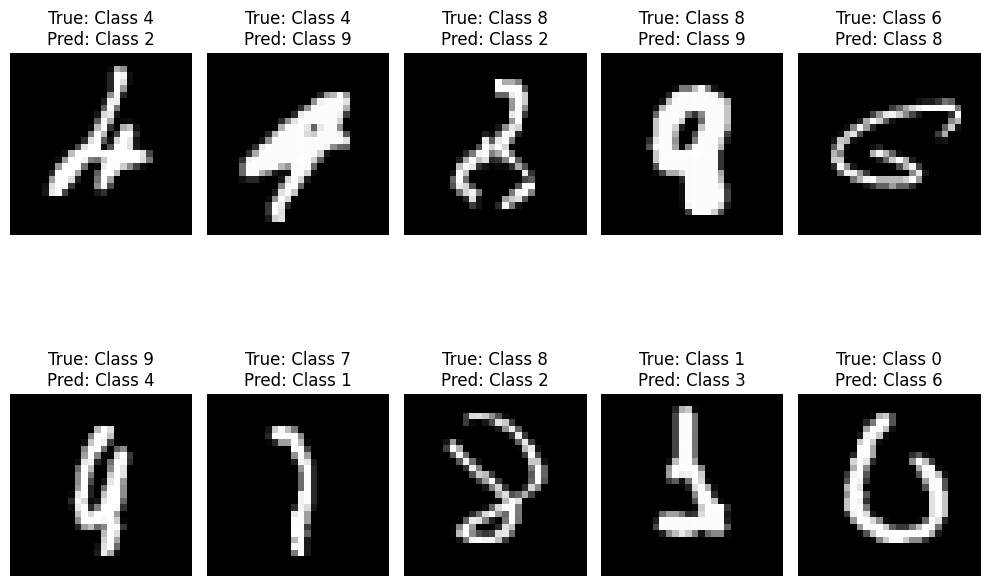

In [48]:
plot_misclassifications(misclf_samples[:10])

In [53]:
misclf_sample_slice = [(gen(sample['corrected_latent_vector']).detach(), sample['label']) for sample in misclf_samples_info[:10]]

misclf_results = [(*misclf_sample, 
                   torch.argmax(cnn(misclf_sample[0])[0]).detach().item()) for misclf_sample in misclf_sample_slice]

In [62]:
n = 15
torch.argmax(cnn(gen(misclf_samples_info[n]['corrected_latent_vector']))[0]), \
misclf_samples_info[n]['label']

(tensor(0), tensor(6))

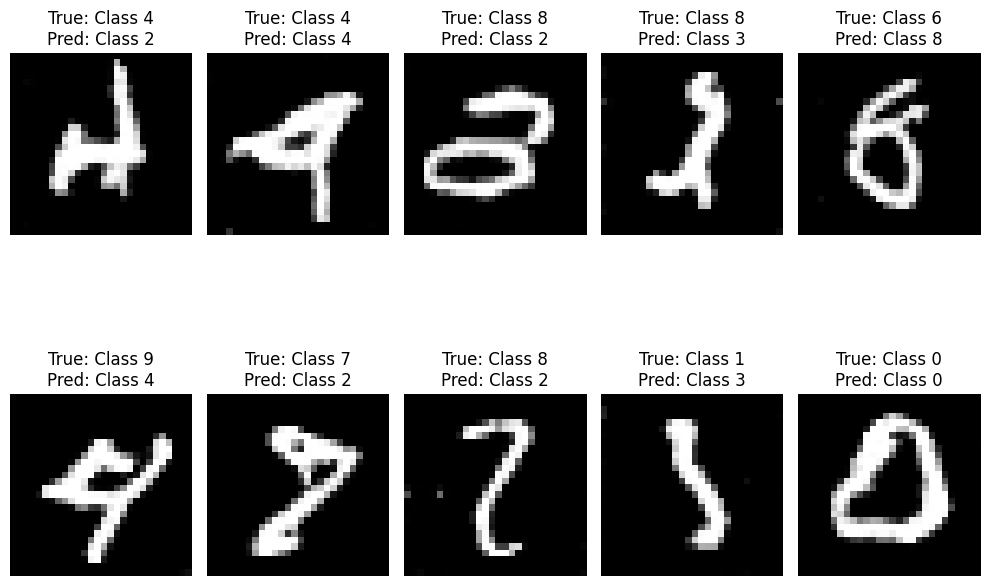

In [54]:
plot_misclassifications(misclf_results) 